# CS470 Introduction to Artificial Intelligence
## Deep Learning Practice 
#### TA. Yechan Hwang
---

### Agenda for this practice
#### 1. Weather dataset
#### 2. Univariate model
#### 3. Normalizing the data
#### 4. Multivariate model
#### 5. Multi-step model
---
<br/>
<br/>
<br/>

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## 6-2. Time series forecasting 
In this practice, we will use two approaches for time series forecasting.
- First, we will forecast a **univariate** time series
- Then we will forecast a **multivariate** time series.

#### The weather dataset
This practice uses a [`weather time series dataset`](https://www.bgc-jena.mpg.de/wetter/) (recorded by the Max-Planck-Institute for Biogeochemistry).

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, we will use only the data collected between 2009 and 2016. 

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


<br/>
The data is in the form of CSV. If you are unfamiliar with handling the CSV data well in Tensorflow, check this tutorial:

[link](https://www.tensorflow.org/tutorials/load_data/pandas_dataframe)

In [3]:
df = pd.read_csv(csv_path)

Let's take a glance at the data.

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
df.tail()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420550,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


As you can see above, an observation is recorded every 10 mintues from 01/01/2009. This means that, you will have 6 observations for a single hour. Similarly, a single day will contain 144 (6x24) observations.

For this prediction problem, you can specify any time period to predict. Let's say **you want to predict the temperature for 6 hours in the future**. And in order to make this prediction, let's say that **you decided to use 5 days of observations**. Then you can create a window containing the last 720 (5x144) observations to train the model and predict 6 hours in the future. Many such configurations are possible and you can choose best one after experiments with various input/output shapes.

<img src="https://github.com/mikodham/CS470/blob/main/Lab3/May%2013/images/example_model.png?raw=1" alt="Drawing" style="width: 1100px;"/>

<br/>

Setting seed to ensure reproducibility.

In [6]:
tf.random.set_seed(13)

## Part 1: Forecast a univariate time series
First, we will train a model that learns **using only a single feature (temperature)** and use this model to make predictions for temperature values in the future.

Let's first extract only the temperature from the dataset.

In [7]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']

print(uni_data.head())
print(uni_data.shape)

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64
(420551,)


<br/>

Let's observe how this data looks across time. By the `plot` function, we can visualize the temperature data.

First we will check global trend of temperature.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6b2618790>],
      dtype=object)

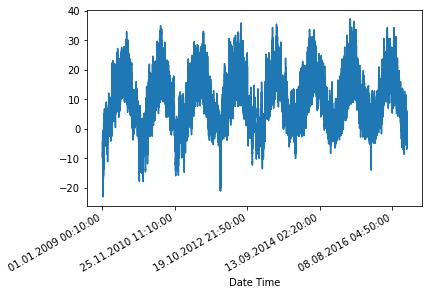

In [8]:
uni_data.plot(subplots=True)

Also we can focus on specific period.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6b53ca450>],
      dtype=object)

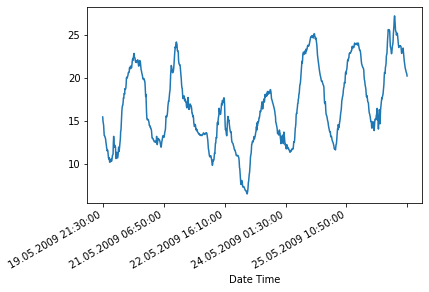

In [9]:
pd.Series(uni_data[20000:21000]).plot(subplots=True)

By using `Series.values`, we convert pandas data to numpy array.

In [10]:
uni_data = uni_data.values
uni_data.shape

(420551,)

In both the following practices, we will use the first 300,000 rows of the data as training dataset and the remaining will be the validation dataset.

This amounts to ~3,000,000 minutes = ~2100 days worth of training data.

In [12]:
TRAIN_SPLIT = 300000
training_data = uni_data[:TRAIN_SPLIT]
# write your code #

It is important to **normalize features before training a neural network**. A common way to do so is by subtracting the mean and dividing by the standard deviation of each feature.

And notice that the **mean and standard deviation should be computed using only the training data**.
When you normalize the whole dataset before splitting, the information from the validation dataset will be included while normalizing, which is not desirable. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance.

In [14]:
training_data_mean = training_data.mean() # write your code #
training_data_std = training_data.std()  # write your code #
print(training_data_mean,training_data_std)

9.233256299999999 8.636720398054864


Let's normalize the data and visualize them.

In [17]:
norm_uni_data = (training_data-training_data_mean)/training_data_std # write your code #

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6aeb37850>],
      dtype=object)

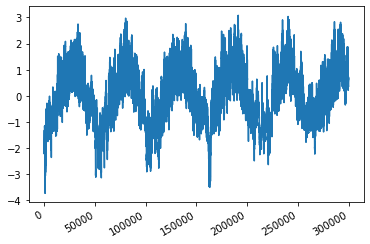

In [18]:
pd.Series(norm_uni_data).plot(subplots=True)

### Univariate model

Let's now **create the data for the univariate model**. In this section, **the model will be given the last 20 recorded temperature observations** and learn to **predict the temperature of the next time step**.

<br/>

<img src="https://github.com/mikodham/CS470/blob/main/Lab3/May%2013/images/approach.png?raw=1" alt="Drawing" style="width: 800px;"/>

<br/>

The helper function below returns the specific windows of time for the model to train on. The parameter `history_size` is the size of the window of past information. So our model will use the number of `history_size` information for prediction. The `target_size` defines how far in the future does the model need to learn to predict. In other words, if the `target_size` 0 is the above model, it will predict the temperature for time step 21 and it will predict the temparature for time step 22 if the `target_size` is 1.

In [19]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)
    
    for i in range(start_index, end_index- target_size):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [22]:
univariate_past_history = 20
univariate_future_target = 0

# Create training dataset with univariate feature
x_train_uni, y_train_uni = univariate_data(norm_uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(norm_uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [23]:
print(x_train_uni.shape)
print(x_val_uni.shape)

(299980, 20, 1)
(0,)


In [24]:
norm_uni_data[:25]

array([-1.99766294, -2.04281897, -2.05439744, -2.0312405 , -2.02660912,
       -2.00113649, -1.95134907, -1.95134907, -1.98492663, -2.04513467,
       -2.08334362, -2.09723778, -2.09376424, -2.09144854, -2.07176515,
       -2.07176515, -2.07639653, -2.08913285, -2.09260639, -2.10418486,
       -2.10418486, -2.09492208, -2.10997409, -2.11692118, -2.13776242])

In [25]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


<br/><br/>

Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [26]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = range(-plot_data[0].shape[0],0)
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

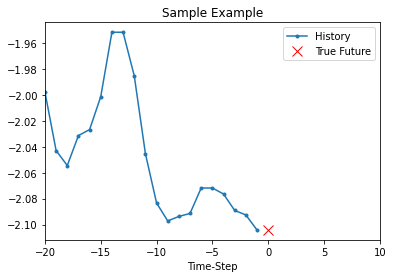

In [29]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

#### Baseline
Before training our model, let's first **construct a simple baseline model**. Baseline model will looks at all the history observations and **predicts the next point to be the average them**.

In [30]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

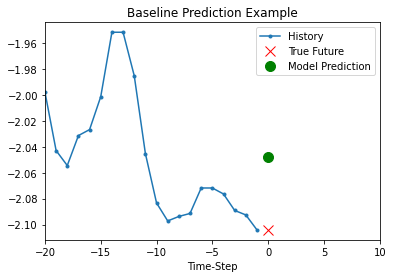

In [31]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if our model can beat this baseline using a recurrent neural network after training.

#### Recurrent neural network

In this practical, we will use a specialized RNN layer Long Short Tem Memory (LSTM).
Similar to RNN and GRU, **LSTMs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far.**

Let's now use `tf.data` to shuffle, make batch, and cache the dataset.

In [44]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [45]:
for elem in train_univariate.take(1):
    print(elem)

(<tf.Tensor: shape=(256, 20, 1), dtype=float64, numpy=
array([[[-1.59936361],
        [-1.60515284],
        [-1.60515284],
        ...,
        [-1.56231251],
        [-1.5646282 ],
        [-1.57157528]],

       [[-1.14896116],
        [-1.14896116],
        [-1.15011901],
        ...,
        [-1.1894858 ],
        [-1.19411719],
        [-1.20222212]],

       [[-1.47663184],
        [-1.49284169],
        [-1.50905155],
        ...,
        [-1.63525686],
        [-1.67115012],
        [-1.70356983]],

       ...,

       [[-0.84792097],
        [-0.84328958],
        [-0.84097388],
        ...,
        [-0.90233977],
        [-0.90697116],
        [-0.9104447 ]],

       [[-1.62367839],
        [-1.62483624],
        [-1.59589007],
        ...,
        [-1.12348853],
        [-1.07601681],
        [-1.02854508]],

       [[-0.64066637],
        [-0.64413991],
        [-0.6487713 ],
        ...,
        [-0.61519374],
        [-0.61750943],
        [-0.62329867]]])>, <tf.Tensor: 

We will make `simple_lstm_model` that has one LSTM with 8 units and one Dense layer with 1 unit.

In [46]:
simple_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1)
    ###################
    #                 #
    # write your code #
    #                 #
    ###################
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model.

In [47]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape) # (BATCH_SIZE, Predicted_value)

Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [48]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
198/200 [============================>.] - ETA: 0s - loss: 0.3651

ValueError: ignored

#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

In [49]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## Part 2: Forecast a multivariate time series
The original dataset contains **fourteen features**. For simplicity, this part **considers only three of the original fourteen**. The features used are air temperature, atmospheric pressure, and air density.

To use more features, add their names to this list.

In [51]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [52]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

In [ ]:
features.plot(subplots=True)

As mentioned, the **first step will be to normalize the dataset** using the mean and standard deviation of the training data.

In [53]:
dataset = features.values
data_mean = dataset.mean(axis=0)# write your code #
data_std = dataset.std(axis=0)# write your code #

In [54]:
dataset = (dataset-data_mean)/data_std# write your code #

#### Single step model
In a single step setup, **the model learns to predict a single point** in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [55]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In this practice, the network will be given past 20 observations, but now each observations have three different features. Therefore, the amount of information the model can refer when making predictions has increased. But at the same time, the amount of information the model has to learn during training has also increased.

Similar to what we did above, our model will be given the last 20 recorded temperature observations and learn to predict the temperature of the next time step.

In [56]:
past_history = 20
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.

In [57]:
# 20 observations with 3 features 
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (20, 3)


In [58]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

Now we will make `single_step_model` that has one LSTM with 32 units and one Dense layer with 1 unit.

In [59]:
single_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
    ###################
    #                 #
    # write your code #
    #                 #
    ###################
    
])

# mae : mean absolute error
single_step_model.compile(optimizer='rmsprop', loss='mae')

Now we will train our model and plot the training and validation loss on the graph.

In [60]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 63s 305ms/step - loss: 0.1523 - val_loss: 0.0351
Epoch 2/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0424 - val_loss: 0.0273
Epoch 3/10
200/200 [==============================] - 4s 21ms/step - loss: 0.0354 - val_loss: 0.0264
Epoch 4/10
200/200 [==============================] - 4s 21ms/step - loss: 0.0315 - val_loss: 0.0232
Epoch 5/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0268 - val_loss: 0.0233
Epoch 6/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0273 - val_loss: 0.0187
Epoch 7/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0253 - val_loss: 0.0203
Epoch 8/10
200/200 [==============================] - 4s 21ms/step - loss: 0.0245 - val_loss: 0.0180
Epoch 9/10
200/200 [==============================] - 4s 21ms/step - loss: 0.0234 - val_loss: 0.0212
Epoch 10/10
200/200 [==============================] - 5s 23ms/step - loss: 0.0218 - val_

In [61]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

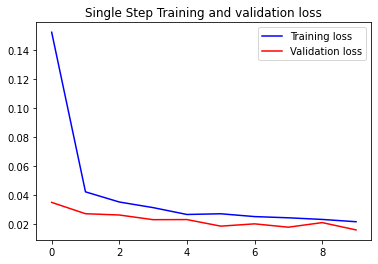

In [62]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions.

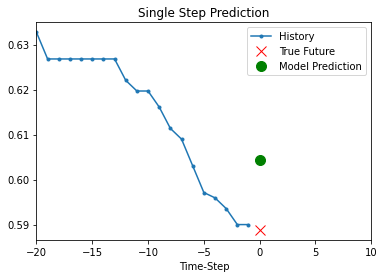

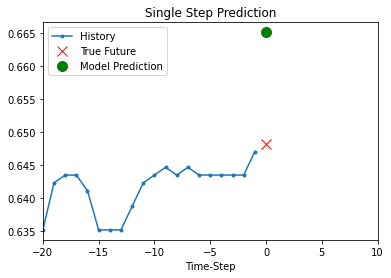

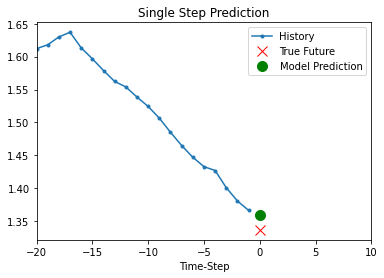

In [63]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 0,
                   'Single Step Prediction')
    
    plot.show()

When we compare our model's prediction with the univariate model, it seems that our model makes predictions better.

##### Will increasing the number of features always increase performance?

It depends on your dataset. While some features have very useful information for your model's prediction, some features may not. In our multivariate model, air density seems to be a little more useful for predicting temperature rather than atmospheric pressure (temperature and air density seems to be in inverse proportion). So when there are many features we can utilize, **deciding which features to include in the training** is also an important issue. 

Although there are various methods for choosing which features to use (e.g. using the feature's statistics, PCA, embedding, etc.), we will not cover them in this practice.

<br/><br/>

#### Multi-step prediction model

In a multi-step prediction model, given a past history, the model needs to learn to **predict a range of future values**. Thus, unlike a single step model, where only a single future point is predicted, **a multi-step model predict a sequence of the future**.

For the multi-step model, **the training data again consists of past 20 observations that have three different features**. However, now the model needs to learn to predict the temperature for the next 3 time steps. For this task, the dataset needs to be preprocessed again so that each target object has 3 labels.


<br/><br/>
<img src="https://github.com/mikodham/CS470/blob/main/Lab3/May%2013/images/multi.png?raw=1" alt="Drawing" style="width: 800px;"/>

In [70]:
past_history = 20
future_target = 0
STEP = 1
future_target = 3

x_train_multi, y_train_multi = multivariate_data(dataset[:,1],0,TRAIN_SPLIT, 1,past_history, future_target, STEP, single_step=False)# write your code #
x_val_multi, y_val_multi = multivariate_data(dataset[:,1],0,TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=False)# write your code #

TypeError: ignored

Let's check out a sample data-point.

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\nTarget temperature to predict : {}'.format(y_train_multi[0].shape))

In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

`multi_step_plot` is a helper function that visualizes many True/Predicted points on the plot.

In [ ]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = range(-len(history),0)
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, **the model now consists of two LSTM layers**. 

`multi_step_model` will have
- LSTM with 32 units as input
- LSTM with 16 units
- Dense layer with 3 units

Note that the last Dense layer has 3 nodes in order to predict 3 target values.

In [ ]:
multi_step_model = tf.keras.models.Sequential([
    tf.layers.keras.LSTM(32, return_sequences=True),
    tf.layers.keras.LSTM(16), 
    tf.layers.keras.Dense(3)
    ###################
    #                 #
    # write your code #
    #                 #
    ###################
    
])

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future. 

In [ ]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

You can experiment with various model configurations and select best one. Your options are as follows:

- Increasae/decrease the context length
- Change the number of labels the model will predict
- Change the number of parameters of LSTM
- Change features to include in learning